In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import keras

import h5py

from random import randint

# where is the DB?
REPLAY_ATTACK_DATA_DIR = '/home/abhir/disk1/data/replayattack/'

/home/abhir/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/abhir/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

# inherit Sequence to allow for multiprocessing of data inputs from files
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, 
                 data_filenames, # list of training/validation/test hd5 filenames
                 labels, # associated labels with given list_IDs
                 batch_size=32, # number of samples per batch
                 dim=(48,136), # dims of one sample -- landmarks on 48 frames
                 n_channels=1, # image/data channels
                 n_classes=2, # num of output labels, could be one-hot-coded on output 
                 shuffle=True,
                 is_training=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.is_training = is_training

                
        self.x = [] # blocks of landmarks -- data X(i)
        self.y = [] # associated label -- Y(i)
        self.filenames = [] # frame block filename
        self.bracket = [] # frame block start and end frames
        
        total_frame_blocks = 0
        i = 0
        for filename in data_filenames:
            print('\t filename = ', filename)
            
            hf = h5py.File('landmarks/' + filename, 'r')
            
            filenames = np.array(hf.get('filenames')) # array of strings
            label = labels[i]
            i = i + 1
            
            total_frames = 0
            num_blocks = 0
            for k in range(0,filenames.shape[0]):
                    
                x = np.array(hf.get('landmarks-{:03d}'.format(k)))
                
                # normalize based on image size
                x = np.multiply(x, [1/320.0, 1/250.0])
                
                # these are overlapping sets of frames from the data    
                for l in range(0,x.shape[0]-dim[0],dim[0]//2):
                    
                    start_frame = l
                    end_frame = l+dim[0]
                    frame_block = x[start_frame:end_frame,:,:] # block of dim[0] frames 
                    
                    if k == 0 and l == 0:
                        print('\t\t frame_block[', l, '].shape = ', l, frame_block.shape)
                    
                    assert frame_block.shape[0] == dim[0]
                    assert frame_block.shape[1] * frame_block.shape[2] == dim[1]
                    
                    self.x.append(frame_block)
                    self.filenames.append(filenames[k])
                    self.bracket.append([start_frame, end_frame])
                    self.y.append(label)
                    num_blocks += 1
                
                frames = x[k].shape[0]
                #print('\t has ', frames, ' frames ')
                total_frames += frames
            
            print('\t\t has ', total_frames, ' frames and ', num_blocks, ' blocks')           
            total_frame_blocks += num_blocks
            
            hf.close()
            
        print('\t total number of frame blocks is ', total_frame_blocks)
        self.indexes = np.arange(len(self.x))
        
        print('\t len(self.x) is ', len(self.x))

        self.fake_blocks = 0
        self.real_blocks = 0
        self.batch_no = 0
        
        self.on_epoch_end()

    def __len__(self): # this the total number of batches per epoch hence #data/batch_size
        'Denotes the number of batches per epoch'
        return len(self.x)//self.batch_size  # hard wired based on what we know about each data sets

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_of_ids = [k for k in indexes]

        # Generate data
        result = self.__data_generation(list_of_ids, self.is_training)
        if self.is_training:
            X, y = result
            return X, y
        else:
            y = result
            return y
        
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
 
        # print('\n\t fake blocks ', self.fake_blocks, ', real blocks ', self.real_blocks)
        self.fake_blocks = 0
        self.real_blocks = 0
        self.batch_no = 0
    
    def __data_generation(self, list_of_ids, is_training):        
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        # X = np.empty((self.batch_size, *self.dim * self.n_channels)) -- for LSTM
        X = np.empty((self.batch_size, *self.dim, self.n_channels)) # -- for CNN

        if self.is_training:
            y = np.empty((self.batch_size), dtype=int)
 
        #print('\t batch_no = ', self.batch_no, ', list of ids for batch: 
        #      ', list_of_ids, ', number in batch is ', len(list_of_ids))
        self.batch_no += 1
        
        #print('\t len(self.x) is ', len(self.x))
        #print('\t len(self.y) is ', len(self.y))
        #print('\t self.x[', list_of_ids[0], '].shape is ', self.x[list_of_ids[0]].shape)

            
        # Generate data
        for i, an_id in enumerate(list_of_ids):  
            #print('\t\t\t i = ', i, ' an_id = ', an_id)
            # Store sample
            X[i] = self.x[an_id].reshape(-1, self.dim[1], self.n_channels)
            
            if is_training:
                # Store class
                y[i] = self.y[an_id]
                
            # keep a count of how many fake and real blocks are used for training in epoch
            if self.y[an_id] == 1:
                self.fake_blocks += 1
            else:
                self.real_blocks += 1

        if is_training:
            return X, y
        else:
            return X

In [3]:
#
batch_size = 48
time_steps = 32
num_landmarks = 68

# Parameters
params = {'dim': (time_steps, num_landmarks*2),
          'batch_size': batch_size,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': True,
          'is_training': True}

# Datasets
#partition = {'train': ['train-attack-fixed.h5', 'train-attack-hand.h5', 'train-real.h5'],
 #           'validation':['devel-attack-fixed.h5', 'devel-attack-hand.h5', 'devel-real.h5'],
 #           'test': ['test-attack-fixed.h5', 'test-attack-hand.h5', 'test-real.h5']} # IDs (normally)
#labels = {'train': [1, 1, 0], 'validation': [1, 1, 0], 'test':[1, 1, 0]} # Labels#partition = {'train': ['train-attack-fixed.h5', 'train-attack-hand.h5', 'train-real.h5'],
partition = {'train': ['train-attack-hand.h5', 'train-real.h5'],
           'validation':['devel-attack-hand.h5', 'devel-real.h5'],
           'test': ['test-attack-hand.h5', 'test-real.h5']} # IDs (normally)
labels = {'train': [1, 0], 'validation': [1, 0], 'test':[1, 0]}

# Generators
training_generator = DataGenerator(partition['train'], labels['train'], **params)
validation_generator = DataGenerator(partition['validation'], labels['validation'], **params)

	 filename =  train-attack-hand.h5
		 frame_block[ 0 ].shape =  0 (32, 68, 2)
		 has  10200  frames and  1950  blocks
	 filename =  train-real.h5
		 frame_block[ 0 ].shape =  0 (32, 68, 2)
		 has  4080  frames and  1320  blocks
	 total number of frame blocks is  3270
	 len(self.x) is  3270
	 filename =  devel-attack-hand.h5
		 frame_block[ 0 ].shape =  0 (32, 68, 2)
		 has  10200  frames and  1950  blocks
	 filename =  devel-real.h5
		 frame_block[ 0 ].shape =  0 (32, 68, 2)
		 has  4080  frames and  1320  blocks
	 total number of frame blocks is  3270
	 len(self.x) is  3270


In [1]:
# test out if the data generator is working by plotting the points back on a block of frames


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
print(cv2.__version__)

k = 2000

frame_block = training_generator.x[k]
filename = training_generator.filenames[k]
bracket = training_generator.bracket[0]

print(filename, ', frames = ', bracket, ', ', frame_block.shape)

start_frame = bracket[0]
end_frame = bracket[1]
num_frames = frame_block.shape[0]

3.3.1


NameError: name 'training_generator' is not defined

In [26]:


mean = np.mean(frame_block,0)
coords = np.multiply(frame_block[j,:,:], [320, 250])

print(coords.shape)

print(np.mean(coords, 0))

(68, 2)
[170.08823529 132.47058824]


In [33]:
coords_flipped = np.multiply(coords, [-1, -1])

print(np.mean(coords_flipped, 0))
coords_flipped = np.add(coords_flipped, [320, 250])

print(np.mean(coords_flipped, 0))

[-170.08823529 -132.47058824]
[149.91176471 117.52941176]


(68, 2)


<Figure size 720x720 with 0 Axes>

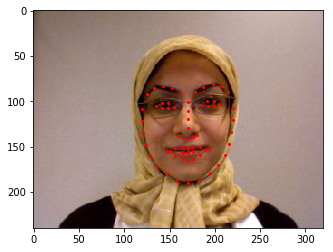

In [22]:
mean = np.multiply(mean, [320, 250])

fig = plt.figure(figsize=(10,10))

fig = plt.subplots()
plt.imshow(img)
plt.scatter(mean[:,0], mean[:,1], c='r', s=4)

plt.show()

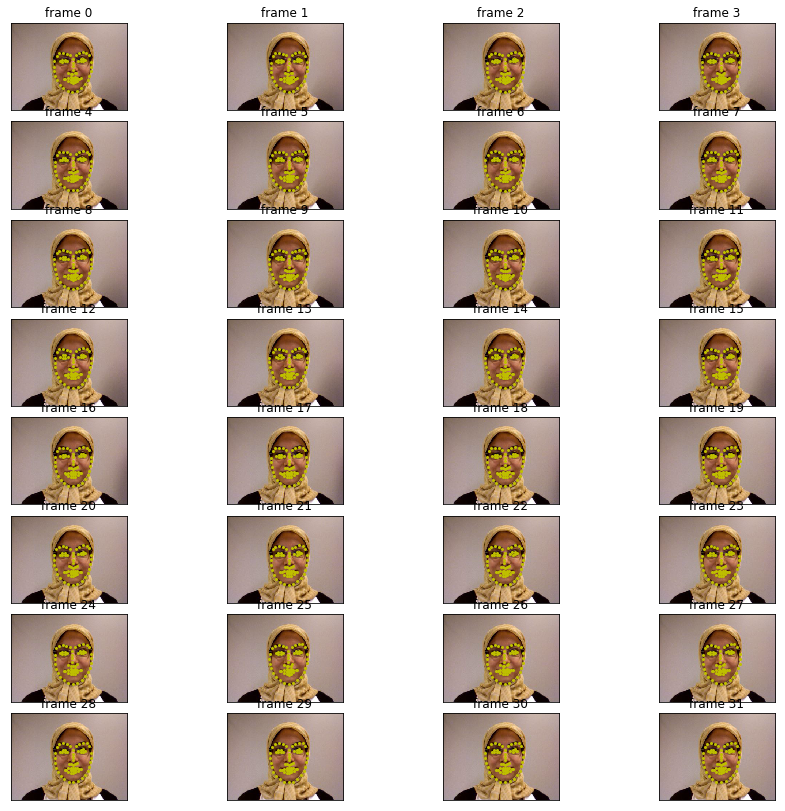

In [21]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0.13, wspace=0.0001, 
                    left=0, right=1, bottom=0.1, top=1)
n = num_frames
count = 1
for j in range(0,num_frames):

    # plot a random image and its coords

    # get coords of file f, frame r
    coords = np.multiply(frame_block[j,:,:], [320, 250])

    # print(coords.shape)
    # x = coords[:,0]
    # y = coords[:,1]
    # print('x range (', np.min(x), ', ', np.max(x), ')')
    # print('y range (', np.min(y), ', ', np.max(y), ')')

    
    all_zeros = not np.any(coords)
    if (all_zeros):
        print('NO LANDMARKS ON FRAME ', start_frame + j)

    # load image frame r from video file f
    full_path = REPLAY_ATTACK_DATA_DIR + filename
    video_cap = cv2.VideoCapture(full_path)

    video_cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame + j)
    success, frame = video_cap.read()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    video_cap.release()

    ax = fig.add_subplot(n/4, 4, count, xticks=[], yticks=[]) 

    # print('Plotting from file ', f, ' frame ', r)
    ax.imshow(img)
    ax.scatter(coords[:,0], coords[:,1], c='y', s=4)
    ax.set_title("frame "+ str(j))

    count += 1

plt.show()